In [ ]:
# Reading the wav files and extracting features from the takes aa very long time. Typically over an hour.
# Instead of doing this everytime and making the TA's wait that long, I wrote the dataframes into csv files
# and commented out all of the extraction code.

# There are two csv files. filesDF stores the raw data of each audio file and df stores the features of these
# audio files. df is created using the data from filesDF, and is then used to make a random forest model.

In [111]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy import signal
from scipy.fft import fftshift
from mpl_toolkits import mplot3d
import librosa
from sklearn.ensemble import RandomForestClassifier
import os

In [3]:
# # Creating base data
# # used to see the wav files and the emotion it's associated with. Don't modify this dataframe. 
# # It'll be used to make the main dataframe
# filesDF = pd.DataFrame(columns=["emotion", "wav"])
# crema = "./Crema/"

# for wav in os.listdir(crema):
#     info = wav.partition(".wav")[0].split("_")
#     if info[2] == 'SAD':
#         filesDF.loc[len(filesDF.index)] = ['sad', librosa.load(crema + wav)[0]]
#     elif info[2] == 'ANG':
#         filesDF.loc[len(filesDF.index)] = ['angry', librosa.load(crema + wav)[0]]
#     elif info[2] == 'DIS':
#         filesDF.loc[len(filesDF.index)] = ['disgust', librosa.load(crema + wav)[0]]
#     elif info[2] == 'FEA':
#         filesDF.loc[len(filesDF.index)] = ['fear', librosa.load(crema + wav)[0]]
#     elif info[2] == 'HAP':
#         filesDF.loc[len(filesDF.index)] = ['happy', librosa.load(crema + wav)[0]]
#     elif info[2] == 'NEU':
#         filesDF.loc[len(filesDF.index)] = ['neutral', librosa.load(crema + wav)[0]]

In [5]:
# # make all audio files the same length
# # longest wav file is ~100000, shortest is ~27000
# # using the middle 20000 samples of every file.
# # This will cut out the periods of quiet at the start and end of every recording
# for i in range(0,len(filesDF)):
#     half_len = len(filesDF["wav"].loc[i])//2
#     filesDF["wav"].loc[i] = filesDF["wav"].loc[i][half_len-10000:half_len+10000]

In [7]:
# # Create dataframe used for manipulation
# df = filesDF.copy()
# df = df.drop(columns=["wav"])

In [47]:
# # declare features

# # mean of the voice amplitude
# df["wav_mean"]=0.0
# # http://librosa.org/doc/main/generated/librosa.stft.html
# df["stft"]=0
# # https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
# df["melspectrogram"]=0.0
# # https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
# df["mfcc"]=0.0
# # https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html
# df["spectral_contrast"]=0.0
# # https://librosa.org/doc/main/generated/librosa.feature.tonnetz.html
# df["tonnetz"]=0.0

# sample_rate = 44100

# def features(wav):
#     # mean
#     mean = abs(wav).mean()
#     # stft
#     stft = librosa.stft(wav)
#     # melspectrogram
#     mel = np.mean(librosa.feature.melspectrogram(wav, sr=sample_rate).T,axis=0).mean()
#     # mfcc
#     mfcc = np.mean(librosa.feature.mfcc(y=wav, sr=sample_rate, n_mfcc=40).T,axis=0).mean()
#     # spectral_contrast
#     contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0).mean()
#     # tonnetz
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(wav), sr=sample_rate).T,axis=0).mean()
#     # return features
#     return mean, stft, mel, mfcc, contrast, tonnetz


# # get features
# for i in range(0,len(df)):
#     mean, stft, mel, mfcc, contrast, tonnetz = features(filesDF.iloc[i][1])
#     # print(mean)
#     df["wav_mean"].iloc[i] = mean
#     df["melspectrogram"].iloc[i] = mel
#     df["mfcc"].iloc[i] = mfcc
#     df["spectral_contrast"].iloc[i] = contrast
#     df["tonnetz"].iloc[i] = tonnetz
#     df["stft"].iloc[i] = stft.mean()

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [64]:
# df = df.drop(columns=["Chorma-stft"])
# print(df.head())
# df.to_csv("df.csv", index=False)
# filesDF.to_csv("filesDF.csv", index=False)

   emotion  wav_mean  melspectrogram      mfcc  Spectral_contrast  Tonnetz  \
0    angry  0.045193        0.723258 -7.985822                0.0      0.0   
1  disgust  0.017393        0.093290 -9.380934                0.0      0.0   
2     fear  0.068280        1.930071 -8.492989                0.0      0.0   
3    happy  0.039849        0.628389 -8.839247                0.0      0.0   
4  neutral  0.019950        0.229698 -9.185984                0.0      0.0   

     contrast                stft   tonnetz  spectral_contrast  
0  102.600239  0.000017+0.000003j -0.018994         102.600239  
1   99.645977  0.000020-0.000004j -0.018729          99.645977  
2  102.473848  0.000011-0.000006j  0.010686         102.473848  
3  100.720320  0.000001+0.000004j -0.004871         100.720320  
4   99.066481  0.000027+0.000002j  0.006331          99.066481  


In [92]:
df = pd.read_csv("df.csv")
df = df.drop(columns=["Tonnetz", "Spectral_contrast", "stft"])

In [93]:
print(df.head())

   emotion  wav_mean  melspectrogram      mfcc    contrast   tonnetz  \
0    angry  0.045193        0.723258 -7.985822  102.600239 -0.018994   
1  disgust  0.017393        0.093290 -9.380934   99.645977 -0.018729   
2     fear  0.068280        1.930071 -8.492989  102.473848  0.010686   
3    happy  0.039849        0.628389 -8.839247  100.720320 -0.004871   
4  neutral  0.019950        0.229698 -9.185984   99.066481  0.006331   

   spectral_contrast  
0         102.600239  
1          99.645977  
2         102.473848  
3         100.720320  
4          99.066481  


In [94]:
# visualize fft. Here we can see the difference in frequencies and power
# when someone is speaking with anger, and with sadness
filesDF = pd.read_csv("filesDF.csv")
print(filesDF.head())
# sig1 = filesDF["wav"].loc[0]
# sig2 = filesDF["wav"].loc[5]
# sig_f1 = abs(np.fft.fft(sig1))
# sig_f2 = abs(np.fft.fft(sig2))
# len_f1 = len(sig_f1)
# len_f2 = len(sig_f2)
# half_len_f1 = int(np.ceil((len_f1 + 1) / 2))
# half_len_f2 = int(np.ceil((len_f2 + 1) / 2))
# sig_f1 = sig_f1[:half_len_f1]
# sig_f2 = sig_f2[:half_len_f2]

# plt.plot(sig_f1)
# plt.plot(sig_f2)
# plt.xlabel("frequency")
# plt.legend(["angry", "sad"])

   emotion                                                wav
0    angry  [ 0.01672083  0.00603863 -0.00215421 ...  0.00...
1  disgust  [-0.00069894  0.01290989  0.01057044 ...  0.00...
2     fear  [-0.30263463 -0.24691129 -0.17649403 ... -0.00...
3    happy  [0.05772104 0.05896825 0.0556751  ... 0.002096...
4  neutral  [-0.00523822 -0.00398716 -0.00391009 ...  0.00...


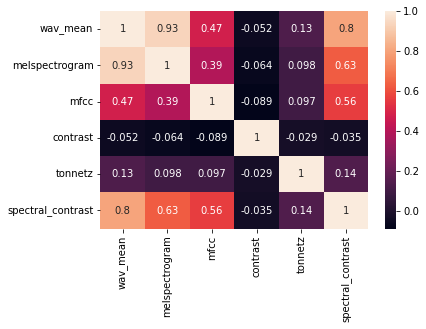

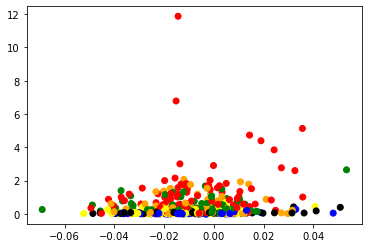

In [108]:
import seaborn as sns
sns.heatmap(df.drop(columns=["emotion"]).corr(), annot=True)
plt.show()

colors = {"sad":"blue", "angry":"red", "disgust":"yellow", "fear":"orange", "happy":"green", "neutral":"black"}
plt.scatter(df["tonnetz"][:500], df["melspectrogram"][:500], c=df["emotion"][:500].map(colors))
plt.show()

4
Chosen depth:  4
Training score for a tree:  0.40440781222003225
Testing score for a tree:  0.37560451370231057


Text(0, 0.5, 'Testing Score')

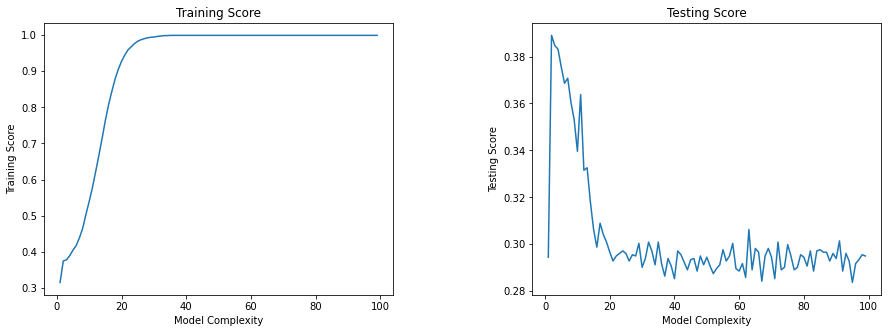

In [104]:
# setup and find best tree depth

# goal and features
goal = df["emotion"]
features = df.drop(columns=["emotion"])

# split data
X_train, X_test, Y_train, Y_test = train_test_split(features, goal)

# graph the change in testing and training scores
train_scores = []
test_scores = []

max_depths = range(1,100)
def best_depth():
    prevScore = 0
    depth = 0
    # find best depth
    for i in max_depths:
        model = tree.DecisionTreeClassifier(max_depth=i)
        model.fit(X_train,Y_train)
        te_score = model.score(X_test, Y_test)
        tr_score = model.score(X_train, Y_train)
        if te_score > prevScore:
            depth = i
            prevScore = tr_score
        
        train_scores.append(tr_score)
        test_scores.append(te_score)
    return depth

depth = best_depth()

print(depth)
print("Chosen depth: ", depth)
print("Training score for a tree: ", train_scores[depth])
print("Testing score for a tree: ", test_scores[depth])

plt.subplots(figsize=(15,5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.plot(max_depths, train_scores)
plt.title('Training Score')
plt.xlabel('Model Complexity')
plt.ylabel('Training Score')
plt.subplot(122)
plt.plot(max_depths, test_scores)
plt.title("Testing Score")
plt.xlabel('Model Complexity')
plt.ylabel('Testing Score')

In [105]:
# use decision tree
model=tree.DecisionTreeClassifier(max_depth=depth)
model.fit(X_train,Y_train)

# training and testing accuracy
dforest_pred_train = model.predict(X_train)
dforest_pred_test = model.predict(X_test) 
print("Train Accuracy: ", accuracy_score(Y_train, dforest_pred_train))
print("Test Accuracy: ", accuracy_score(Y_test, dforest_pred_test))

# keras simplest
# pytorch
# tensor flow
# specified NN for time series

Train Accuracy:  0.3893567461028489
Test Accuracy:  0.3831273508866201


In [121]:
# use knn
knn=KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train,Y_train)

# training and testing accuracy
knn_pred_train = knn.predict(X_train)
knn_pred_test = knn.predict(X_test) 
print("Train Accuracy: ", accuracy_score(Y_train, knn_pred_train))
print("Test Accuracy: ", accuracy_score(Y_test, knn_pred_test))

Train Accuracy:  0.40118258376635013
Test Accuracy:  0.35948414830736164
